In [2]:
from typing import Mapping, Dict, Optional, Tuple
from rl.distribution import Categorical
from rl.markov_process import FiniteMarkovRewardProcess
from dataclasses import dataclass

## Implement 2D random walk MRP process

In [8]:
@dataclass(frozen=True)
class position2D:
    i: int
    j: int


class RandomWalkMRP_2D(FiniteMarkovRewardProcess[position2D]):
    '''
    Extended from rl/chapter10/random walk mrp.py
    '''
    B1: int
    B2: int
    p_up: float
    p_down: float
    p_left: float


    def __init__(
        self,
        B1: int,
        B2: int,
        p_up: float,
        p_down: float,
        p_left: float
    ):
        self.B1 = B1
        self.B2 = B2
        self.p_up = p_up
        self.p_down = p_down
        self.p_left = p_left
        self.p_right = 1 - p_up - p_down - p_left
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> Mapping[position2D, Optional[Categorical[Tuple[position2D, float]]]]:
            d: Dict[position2D, Optional[Categorical[Tuple[position2D, float]]]] = {}

            for i in range(1,self.B1):
                for j in range(1,self.B2):
                    d[position2D(i,j)] = Categorical({(position2D(i+1,j),0. if i<self.B1-1 else 1.): self.p_down,
                                                      (position2D(i-1,j),0.): self.p_up,
                                                      (position2D(i,j+1),0. if j<self.B2-1 else 1.): self.p_right,
                                                      (position2D(i,j-1),0.): self.p_left
                                                      })

            for j in range(self.B2):
                d[position2D(0,j)] = None
                d[position2D(self.B1,j)] = None
            for i in range(self.B1):
                d[position2D(i,0)] = None
                d[position2D(i,self.B2)] = None

            return d

## Compare Convergence of TD and MC

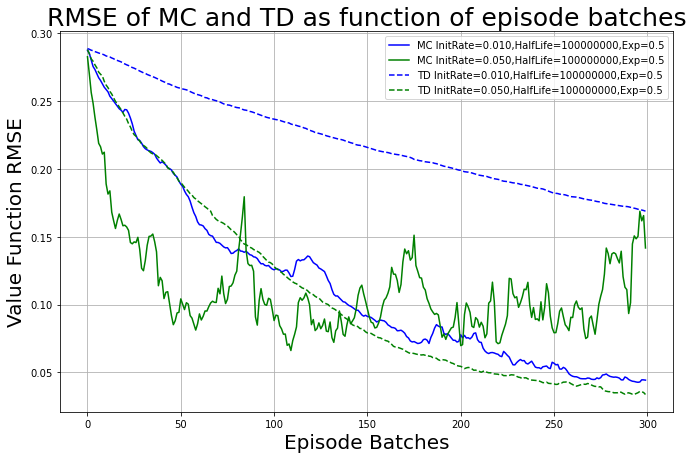

In [11]:
from rl.chapter10.prediction_utils import compare_td_and_mc
this_B1: int = 10
this_B2: int = 10
this_p_up: float = 0.25
this_p_down: float = 0.25
this_p_left: float = 0.25
random_walk: RandomWalkMRP_2D = RandomWalkMRP_2D(
        B1 = this_B1,
        B2 = this_B2,
        p_up = this_p_up,
        p_down = this_p_down,
        p_left = this_p_left
    )
compare_td_and_mc(
        fmrp=random_walk,
        gamma=1.0,
        mc_episode_length_tol=1e-6,
        num_episodes=2100,
        learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
        initial_vf_dict={s: 0.5 for s in random_walk.non_terminal_states},
        plot_batch=7,
        plot_start=0
    )



Like in 1D, MC has significantly more variance than TD. RMSE of MC decrease faster than TD
at the begining with learning rate $\alpha = 0.05$ but TD reach small rmse faster in the end.
However, at $\alpha = 0.01$, MC outperforms TD in this case.

